# Training the speech synthesis model - 3rd try

## Loading and cleaning spectrogram data

The first step that will be needed is to load spectrogram data. Since some files are missing, a few of the spectrograms will be completely empty and we would like to remove those.

Challenge: Demonstrate that MXNet is a state-of-the-art deep learning framework

Why is it important: Cloud providers sell infrastructure specialized at running their frameworks. Owning a popular framework helps providers sell cloud services, which are becoming increasingly popular.

What we are doing:
Implementing an end-to-end text-to-speech system in MXNet (Tacotron) to showcase the framework.

Tacotron in MXNet
From text directly to speech

Deep learning with MXNet


In [1]:
#!pip install --pre --upgrade mxnet-cu90
#!pip uninstall -y gluonnlp

In [2]:
#!pip install --pre --upgrade mxnet-cu90

In [3]:
import numpy as np
import mxnet as mx
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn, Block
from util import audio
import matplotlib.pyplot as plt
import pickle

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/tensorflow/python/framework/ops.py:939: DeprecationWarning: builtin type EagerTensor has no __module__ attribute
  EagerTensor = c_api.TFE_Py_InitEagerTensor(_EagerTensorBase)
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


In [4]:
#load everything
lstTextEncodings = pickle.load( open( "data/lsttxtencodings.p", "rb" ) )
lst_linspectrograms = pickle.load( open( "data/lstlinspectrograms.p", "rb" ) )
lst_melspectrograms = pickle.load( open( "data/lstmelspectrograms.p", "rb" ) )

Let us do some sanity check. We know that audio 400 is:

She never @ went back to school , # even later on when both of their sons were older , @ # and she thinks that Jeff's criticisms grew out of what he saw as her lack @ of ambition . # 

File: HAW-157-02

In [5]:
linspectrogram = lst_linspectrograms[400]
melspectrogram = lst_melspectrograms[400]
lstTextEncodings[400]

array([24, 13, 10,  0, 19, 10, 27, 10, 23,  0,  2,  0, 28, 10, 19, 25,  0,
        7,  6,  8, 16,  0, 25, 20,  0, 24,  8, 13, 20, 20, 17,  0,  3,  0,
        2,  0, 10, 27, 10, 19,  0, 17,  6, 25, 10, 23,  0, 20, 19,  0, 28,
       13, 10, 19,  0,  7, 20, 25, 13,  0, 20, 11,  0, 25, 13, 10, 14, 23,
        0, 24, 20, 19, 24,  0, 28, 10, 23, 10,  0, 20, 17,  9, 10, 23,  0,
        3,  0,  2,  0,  2,  0,  6, 19,  9,  0, 24, 13, 10,  0, 25, 13, 14,
       19, 16, 24,  0, 25, 13,  6, 25,  0, 15, 10, 11, 11,  2, 24,  0,  8,
       23, 14, 25, 14,  8, 14, 24, 18, 24,  0, 12, 23, 10, 28,  0, 20, 26,
       25,  0, 20, 11,  0, 28, 13,  6, 25,  0, 13, 10,  0, 24,  6, 28,  0,
        6, 24,  0, 13, 10, 23,  0, 17,  6,  8, 16,  0,  2,  0, 20, 11,  0,
        6, 18,  7, 14, 25, 14, 20, 19,  0,  4,  0,  2,  0])

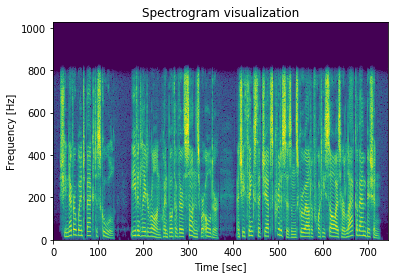

In [6]:
plt.pcolormesh(linspectrogram)
plt.title('Spectrogram visualization')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

We can also synthesize the audio to make sure it corresponds to what it should.

In [7]:
%%time
reconst_wav = audio.inv_spectrogram(linspectrogram)

Reconstructing with 60 iterations
CPU times: user 8.23 s, sys: 36 ms, total: 8.27 s
Wall time: 8.23 s


In [8]:
audio.save_wav(path='data/reconstrSANITYTrain.wav', wav=reconst_wav)

Let us now find and delete rows that correspond to blanks.

For the convolution we also need to remove files that have sentence length greater than a fixed value, or spectrogram size greater than some value.

In [9]:
emptyIdx = []
for i in range(len(lst_linspectrograms)):
    spec = lst_linspectrograms[i]
    if np.count_nonzero(spec) == 0:
        #print('{}-th index is all zeros'.format(i))
        emptyIdx.append(i)
print(len(emptyIdx))

71


In [10]:
lstTextEncodings = [i for j, i in enumerate(lstTextEncodings) if j not in emptyIdx]
lst_linspectrograms = [i for j, i in enumerate(lst_linspectrograms) if j not in emptyIdx]
lst_melspectrograms = [i for j, i in enumerate(lst_melspectrograms) if j not in emptyIdx]

One last thing: if not all files have been processed, the text encodings will have more samples than the spectrograms.

In [11]:
lstTextEncodings = lstTextEncodings[:len(lst_linspectrograms)]
len(lstTextEncodings)

3143

In [12]:
nmax = 3200
lstTextEncodings = lstTextEncodings[:nmax]
lst_linspectrograms = lst_linspectrograms[:nmax]
lst_melspectrograms = lst_melspectrograms[:nmax]
len(lst_melspectrograms)

3143

In [13]:
import psutil
mem = psutil.virtual_memory()
mem.available/mem.total

0.8879061140008834

## Padding

If we are going to use convolutions, we actually need to pad everything to a fixed size.

In [14]:
max_sentence_length = 200
max_spectrog_width  = 800
repeater = max_spectrog_width//max_sentence_length

In [15]:
padded_encodings = []
padded_linspecs  = []
nTextEncs = len(lstTextEncodings)
for k in range(nTextEncs):
    if lstTextEncodings[k].shape[0] < max_sentence_length and lst_linspectrograms[k].shape[1] < max_spectrog_width:
        p_e = np.pad(lstTextEncodings[k], (0,  max_sentence_length - lstTextEncodings[k].shape[0]), 'constant', constant_values=(0, 0))
        padded_encodings.append(p_e.repeat(repeater))
        
        linspecw = max_spectrog_width - lst_linspectrograms[k].shape[1]
        p_lin = np.pad(lst_linspectrograms[k], ((0,0), (0,linspecw)), 'constant', constant_values=((0, 0),(0,0)) )
        padded_linspecs.append(p_lin)

## Gluon dataloader / dataset

In [16]:
ctx = mx.gpu(0)
dataset = mx.gluon.data.dataset.ArrayDataset(padded_encodings, padded_linspecs)

In [17]:
from multiprocessing import cpu_count
CPU_COUNT = cpu_count()

data_loader = mx.gluon.data.DataLoader(dataset, batch_size=8, num_workers=CPU_COUNT)

#for X_batch, y_batch in data_loader:
#    print("X_batch has shape {}, and y_batch has shape {}".format(X_batch.shape, y_batch.shape))

## Create conv model

In [25]:
class SpeechDNN(gluon.Block):
    def __init__(self, **kwargs):
        super(SpeechDNN, self).__init__(**kwargs)
        
        with self.name_scope():
            self.embedding = nn.Embedding(input_dim=32, output_dim=1025)
            self.conv1 = nn.Conv2D(4, kernel_size=(5,5), padding=(2,2), activation = 'relu' )
            self.bn1   = nn.BatchNorm()
            
            self.conv2 = nn.Conv2D(8, kernel_size=(5,5), padding=(2,2), activation = 'relu' )
            self.bn2   = nn.BatchNorm()
            
            self.mp1   = nn.MaxPool2D(pool_size=(3,3), strides = (1,1), padding=(1,1))
            self.conv3 = nn.Conv2D(12, kernel_size=(5,5), padding=(2,2), activation = 'relu' )
            self.bn3   = nn.BatchNorm()
            
            self.conv4 = nn.Conv2D(8, kernel_size=(5,5), padding=(2,2), activation = 'relu' )
            #self.conv5 = nn.Conv2D(120, kernel_size=(5,5), padding=(2,2), activation = 'relu' )

            self.convOut = nn.Conv2D(1, kernel_size=(1,1), padding=(0,0) )
            
    def forward(self, x):
        x = self.embedding(x)
        
        x = x.transpose((0,2,1))
        #add channel
        x = x.reshape((x.shape[0], 1, x.shape[1], x.shape[2]))
        
        x = self.conv1(x)
        x = self.bn1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)

        x = self.mp1(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.conv4(x)
        #x = self.conv5(x)
        
        x = self.convOut(x)              
        
        #remove channels
        x = x.reshape((x.shape[0], x.shape[2], x.shape[3]))
        
        return x

In [26]:
sdnn = SpeechDNN()
sdnn.initialize(ctx=ctx)

In [27]:
v = nd.array(padded_encodings[5], dtype=int).as_in_context(ctx)
v = v.reshape(1,v.shape[0])
v.shape

(1, 800)

In [28]:
sdnn(v).shape

(1, 1025, 800)

## Training


In [29]:
sdnnSpeech = SpeechDNN()
sdnnSpeech.collect_params().initialize(mx.init.Xavier(), ctx=ctx)

In [30]:
desired_loss = gluon.loss.L1Loss()
scheduler = mx.lr_scheduler.FactorScheduler(10000, 0.96,1e-6)
trainer = gluon.Trainer(sdnnSpeech.collect_params(), 'adam', {'learning_rate': .002, 'lr_scheduler': scheduler, 'clip_gradient':0.3})

In [31]:
epochs = 1500
for epoch in range(epochs):
    # training loop (with autograd and trainer steps, etc.)
    cumulative_train_loss = 0 #mx.nd.zeros(1, ctx=ctx)
    training_samples = 0
    for batch_idx, (data, label) in enumerate(data_loader):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        
        
        with autograd.record():
            output = sdnnSpeech(data)
            #print('shapes: data {} label {} output {}'.format(data.shape, label.shape, output.shape))
            loss = desired_loss(output, label)
        loss.backward()
        trainer.step(data.shape[0])
        cumulative_train_loss += loss.sum().asnumpy()
        training_samples += data.shape[0]
        print('Minibatch {} Loss = {} '.format(batch_idx, cumulative_train_loss/training_samples), end='\r')
        
        
    train_loss = cumulative_train_loss/training_samples
    if epoch % 10 == 0:
        sdnnSpeech.save_params('models/dnnspeech-epoch{}.model'.format(epochNumber))

    print("Epoch {}, training loss: {}".format(epoch, train_loss))

NameError: name 'tcn' is not defined

In [ ]:
sentence, true_spec = dataset[15]

In [ ]:
plt.pcolormesh(true_spec)
plt.show()

In [ ]:
ndsent = nd.array(sentence.reshape(1,sentence.shape[0])).as_in_context(ctx)
ndsent.shape

In [ ]:
ndpred_spec = sdnnSpeech(ndsent)
pred_spec = ndpred_spec.asnumpy().reshape((ndpred_spec.shape[1],ndpred_spec.shape[2]))
pred_spec.shape

In [ ]:
plt.pcolormesh(pred_spec)
plt.show()